## Simulate the runout of a 5 meter high pile of debris that suddenly collapses

### import necessary packages and components

In [1]:
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import numpy as np

from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FlowDirectorMFD
from landlab import imshowhs_grid, imshow_grid
from landlab.components.mass_wasting_router import MassWastingRunout

### define the model domain, geometry of the pile and MassWastingRunout parameters Sc, qsi and k

In [2]:
# model domain
r = 51 # rows in model domain
c = r # columns
dxdy = 5 # cell size
hs = 1 # soil thickness
Dp = 0.2 # maximum particle diameter in soil

# define the pile
ls_h = 5 # height of pile
w = 5 # width of pile

# MassWastingRunout parameters
Sc = [0.03]  # critical slope
qsi = 0.01 # threshold flux
k = 0.02 # scour coefficient

### create model grid and add necessary grid fields

In [3]:
mg = RasterModelGrid((r,c),dxdy)

dem = mg.add_field('topographic__elevation',
                    np.ones(r*c)*1,
                    at='node')

mg.at_node['node_id'] = np.hstack(mg.nodes)
# domain for plots
xmin = mg.node_x.min(); xmax = mg.node_x.max(); ymin = mg.node_y.min(); ymax = mg.node_y.max()
# set boundary conditions, add flow direction
mg.set_closed_boundaries_at_grid_edges(True, True, True, True) #close all boundaries
# flow directions
fa = FlowAccumulator(mg, 
                      'topographic__elevation',
                      flow_director='FlowDirectorD8')
fa.run_one_step()
# soil thickness
thickness = np.ones(mg.number_of_nodes)*hs
mg.add_field('node', 'soil__thickness',thickness)
# set particle diameter
mg.at_node['particle__diameter'] = np.ones(len(mg.node_x))*Dp
# copy of initial topography
DEMi = mg.at_node['topographic__elevation'].copy()

### run flow director to add slope and receiving node fields

In [4]:
mg.delete_field(loc = 'node', name = 'flow__sink_flag')
mg.delete_field(loc = 'node', name = 'flow__link_to_receiver_node')
mg.delete_field(loc = 'node', name = 'flow__receiver_node')
mg.delete_field(loc = 'node', name = 'topographic__steepest_slope')
fd = FlowDirectorMFD(mg, diagonals=True,
                      partition_method = 'square_root_of_slope')
fd.run_one_step()

### create the pile

In [5]:
# find central point in domain
x = mg.node_x.max()/2
y = mg.node_y.max()/2

# find all nodes with radius of central point
dn = ((mg.node_x-x)**2+(mg.node_y-y)**2)**0.5
pile_nodes = np.hstack(mg.nodes)[dn<w*mg.dx]

# set those nodes as the landslide (they're all given the same mass__wasting_id number)
mg.at_node['mass__wasting_id'] = np.zeros(mg.number_of_nodes).astype(int)
mg.at_node['mass__wasting_id'][pile_nodes] = 1

# set thickness of landslide (in this case the pile)
mg.at_node['soil__thickness'][pile_nodes] = ls_h
mg.at_node['topographic__elevation'][pile_nodes] =   mg.at_node['topographic__elevation'][pile_nodes]+(ls_h-hs)

### take a look at the pile

Zmin1.0, Zmax5.0


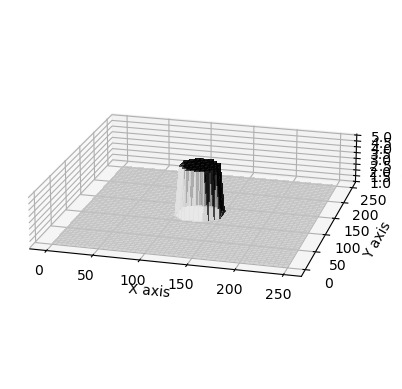

In [6]:
# borrow the plotting routine from the flow-director notebooks to make a 3d plot of our surface.
# import plotting tools
def surf_plot_ani(mg,
              surface='topographic__elevation',
              title='', zlim = None):

    # Plot the surface.
    Z = mg.at_node[surface].reshape(mg.shape)
    print('Zmin{}, Zmax{}'.format(Z.min(), Z.max()))
    color = cm.gray_r((Z - Z.min())*2 / (Z.max() - Z.min()))
    surf = ax.plot_surface(mg.x_of_node.reshape(mg.shape),
                           mg.y_of_node.reshape(mg.shape),
                           Z,
                           rstride=1,
                           cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False,
                          alpha = 0.67)
    ax.view_init(elev=20, azim=-75)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    ax.set_box_aspect([1, 1, 0.2])
    if zlim:
        ax.set_zlim(zlim)
    plt.show()
    return surf

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
a = surf_plot_ani(mg)

### view a shaded hillshade of the map, colored according to elevation

<Axes: xlabel='Easting', ylabel='Northing'>

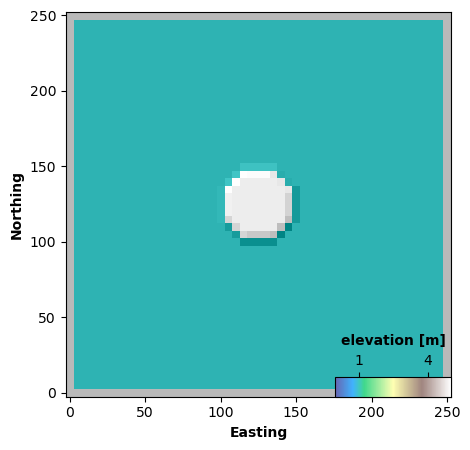

In [7]:
# 2d view
plt.figure(figsize = (5,5))
imshowhs_grid(mg,
            'topographic__elevation',
            drape1 = 'topographic__elevation',
            cmap = 'terrain',
            var_name = 'elevation [m]',
            allow_colorbar=True,
            colorbar_label_y = -45,
            plot_type=  "Drape1",
            limits = (0,5),
            alpha = 0.75,
            altdeg=37., azdeg=210)

### that's a nice looking pile...now set up an instance of MassWastingRuntout to model its collapse and runout 

In [8]:
mw_dict = {'critical slope':Sc, 'threshold flux':qsi,
            'scour coefficient':k, 'effective particle diameter':Dp}
MWRu = MassWastingRunout(mg, mw_dict, effective_qsi = False, save = True, grain_shear = False, settle_deposit = True)

### run the instance of MassWastingRunout

In [9]:
start_time = time.time()
MWRu.run_one_step(run_id = 0)

### view runout extent

Zmin1.0, Zmax2.493460513790849


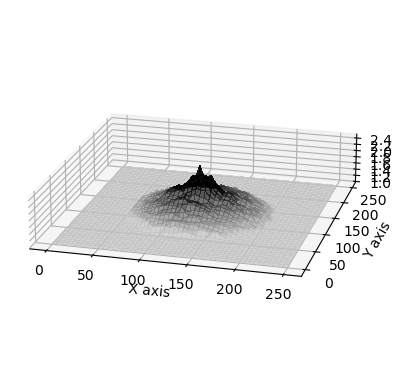

In [10]:
# 3d view
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf_plot_ani(mg)

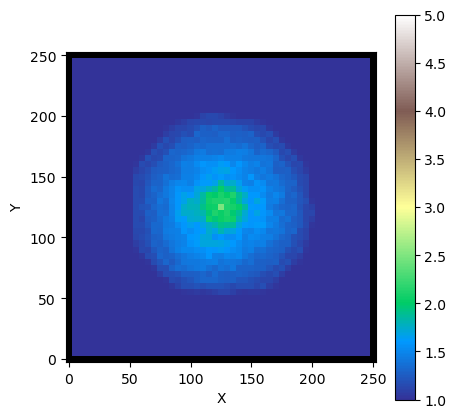

In [11]:
#shaded hillshade, colored by elevation
plt.figure(figsize = (5,5))
# imshowhs_grid(mg,
#             'topographic__elevation',
#             drape1 = 'topographic__elevation',
#             cmap = 'terrain',
#             var_name = 'elevation [m]',
#             allow_colorbar=True,
#             colorbar_label_y = -45,
#             plot_type=  "Drape1",
#             limits = (0,5),
#             alpha = 0.75,
#             altdeg=37., azdeg=210)
imshow_grid(mg,
            'topographic__elevation', 
              cmap = 'terrain',
             limits = (1,5))

### view topographic change caused by the runout

<Axes: xlabel='Easting', ylabel='Northing'>

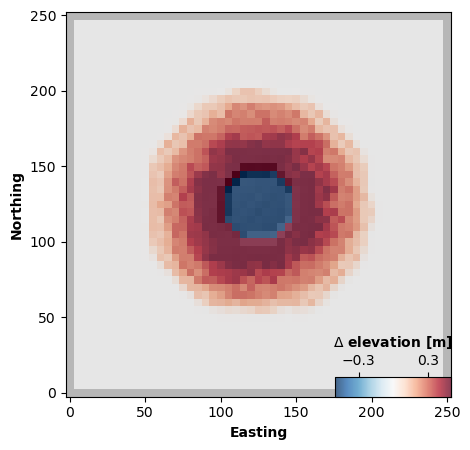

In [12]:
mg.at_node['dem_dif_o'] = mg.at_node['topographic__elevation']-mg.at_node['topographic__initial_elevation']

plt.figure(figsize = (5,5))
imshowhs_grid(mg,
            'dem_dif_o',
            drape1 = 'dem_dif_o',
            cmap = 'RdBu_r',
            var_name = r'$\Delta$ elevation [m]',
            allow_colorbar=True,
            colorbar_label_y = -45,
            plot_type=  "Drape1",
            limits = (-0.5,0.5),
            alpha = 0.75,
            altdeg=37., azdeg=210)


### view of the pile as it ranout

#### first in 3d view

<IPython.core.display.Javascript object>


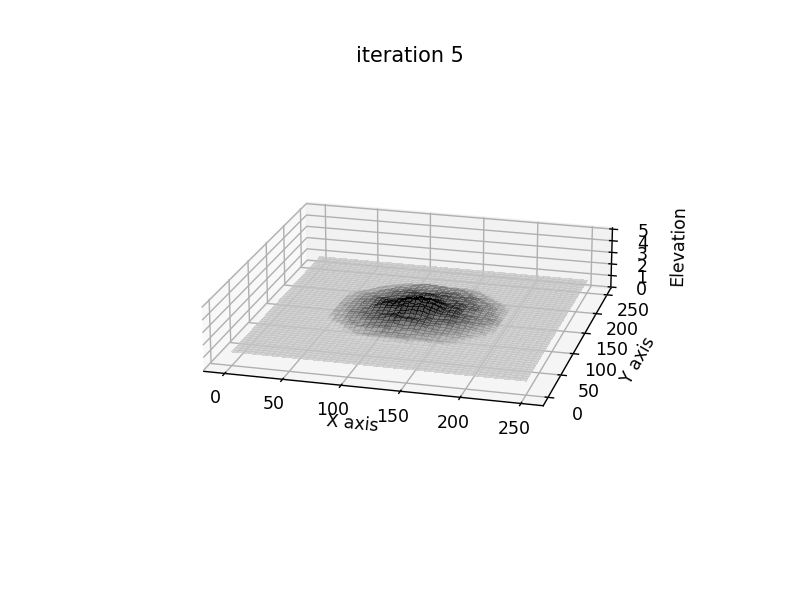

Zmin1.0, Zmax5.0


In [13]:
# modified
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook
def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][frame_number]
    plot[0].remove()
    plot[0] = surf_plot_ani(mg ,'topographic__elevation','iteration '+str(frame_number),zlim = [0,5])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

nmax=len(MWRu.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
plot = [surf_plot_ani(mg ,'topographic__elevation','iteration '+str(0),zlim = [0,5])]
animate = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot), blit = True, repeat = True)
plt.show()

#### now in 2d view

<IPython.core.display.Javascript object>


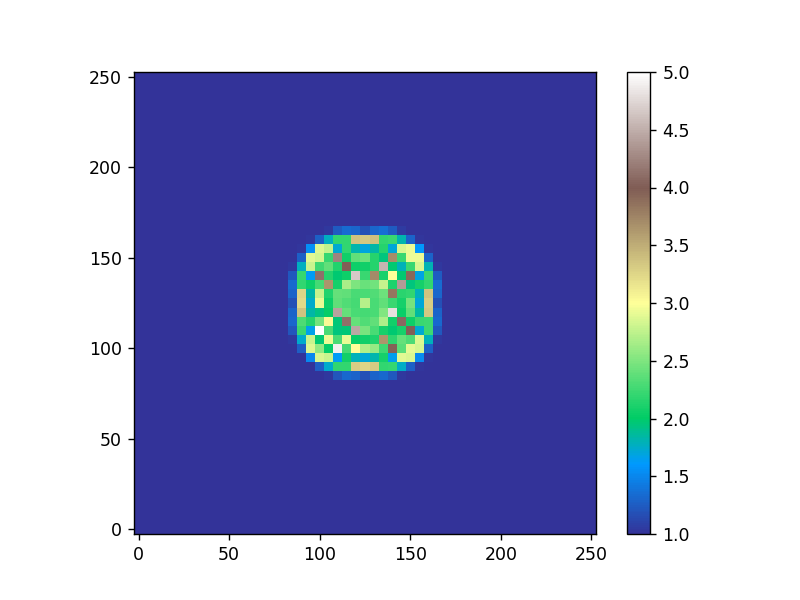

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook

# plotting function
def plot_vals(field = 'topographic__elevation', cmap = "terrain"):
    grid = mg
    values = grid.at_node[field]
    values = values.reshape(grid.shape)
    y = (
        np.arange(values.shape[0] + 1) * grid.dy
        - grid.dy * 0.5
        + grid.xy_of_lower_left[1]
    )
    x = (
        np.arange(values.shape[1] + 1) * grid.dx
        - grid.dx * 0.5
        + grid.xy_of_lower_left[0]
    )
    myimage = plt.pcolormesh(x, y, values, cmap = cmap, alpha = 1)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)
    return myimage

# update function
def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][frame_number]
    plot[0].remove()
    plot[0] = plot_vals()

# prepare the first frame
fig = plt.figure()
nmax=len(MWRu.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
plot = [plot_vals()]
cb = plt.colorbar(norm=True)


animate_1 = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot), blit = True, repeat = True)
plt.show()

In [20]:
mg.at_node['drainage_area']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

<IPython.core.display.Javascript object>


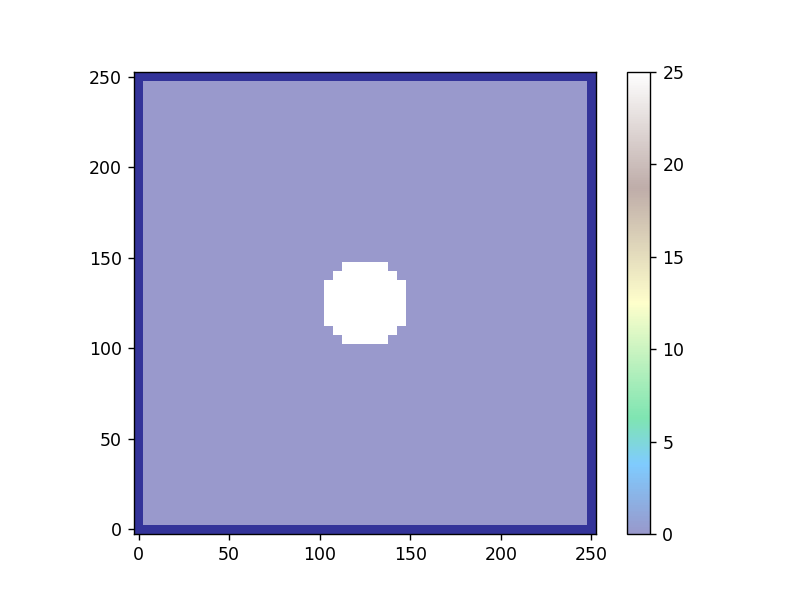

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
%matplotlib notebook

# plotting function
def plot_vals(field = 'topographic__elevation', cmap = "terrain"):
    grid = mg
    def get_values_xy(field):
        values = grid.at_node[field]
        values = values.reshape(grid.shape)
        y = (
            np.arange(values.shape[0] + 1) * grid.dy
            - grid.dy * 0.5
            + grid.xy_of_lower_left[1]
        )
        x = (
            np.arange(values.shape[1] + 1) * grid.dx
            - grid.dx * 0.5
            + grid.xy_of_lower_left[0]
        )
        return x, y, values
    x,y,values = get_values_xy('topographic__elevation')
    myimage = plt.pcolormesh(x, y, values, cmap = cmap, alpha = 1)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)
    
    x,y,values = get_values_xy('drainage_area')
    myimage = plt.pcolormesh(x, y, values, cmap = cmap, alpha = 0.5)
    myimage.set_rasterized(True)
    myimage.axes.set_aspect("equal")
    plt.autoscale(tight=True)    
    
    return myimage

# update function
def update_plot(frame_number, MWRu, plot):
    mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][frame_number]
    plot[0].remove()
    plot[0] = plot_vals()

# prepare the first frame
fig = plt.figure()
nmax=len(MWRu.runout_evo_maps[0].keys())
mg.at_node['topographic__elevation'] = MWRu.runout_evo_maps[0][0]
plot = [plot_vals()]
cb = plt.colorbar(norm=True)


animate_1 = animation.FuncAnimation(fig, update_plot, nmax, fargs=(MWRu, plot), blit = True, repeat = True)
plt.show()

#### and finally, in profile view

<IPython.core.display.Javascript object>


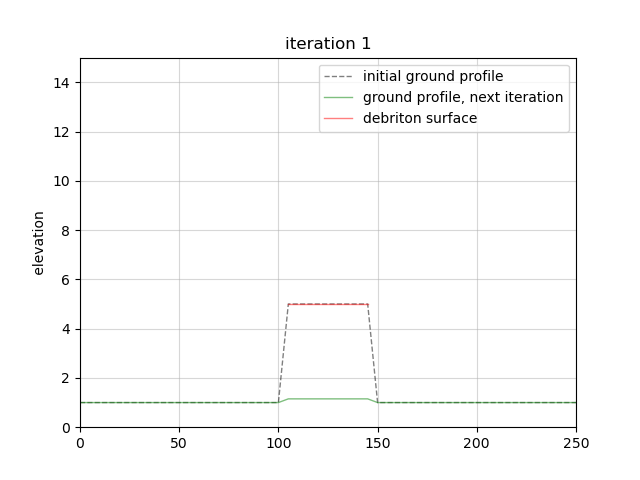

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

# get profile nodes
pf = mg.nodes[int((r-1)/2),:]
x_ = mg.node_x[pf]

# create profile of the initial pile
y = mg.at_node['topographic__initial_elevation'][pf]
etopo = MWRu.runout_evo_maps[0][0]
topo = MWRu.topo_evo_maps[0][0]               
y_ = topo[pf]
_y_ = etopo[pf]
d = _y_ - y_; _y_[d == 0] = np.nan

# prepare the first frame
fig, ax = plt.subplots()
y_i_l = ax.plot(x_,y,'k--', alpha = 0.5, linewidth = 1,label = 'initial ground profile')
g_l, = ax.plot(x_,y_,'g-', alpha = 0.5, linewidth = 1, label = 'ground profile, next iteration')
d_l, = ax.plot(x_,_y_,'r-', alpha = 0.5, linewidth = 1, label = 'debriton surface')
ax.set_ylim(0,ls_h*3); ax.set_ylabel(' elevation ')
ax.set_xlim([0, max(mg.node_x)])
ax.legend()
ax.grid(alpha = 0.5)  
ax.set_title('iteration '+str(0))

# update function
def update(frame):
    etopo = MWRu.runout_evo_maps[0][frame]
    topo = MWRu.topo_evo_maps[0][frame]
    y = mg.at_node['topographic__initial_elevation'][pf]
    y_ = topo[pf]
    _y_ = etopo[pf]
    d = _y_ - y_; _y_[d == 0] = np.nan
    g_l.set_xdata(x_)
    g_l.set_ydata(y_)
    d_l.set_xdata(x_)
    d_l.set_ydata(_y_)
    ax.set_title('iteration '+str(frame))
    return (g_l, d_l)
frames = len(MWRu.runout_evo_maps[0].keys())
animate = animation.FuncAnimation(fig, update, frames=frames, interval=200, blit = True)
plt.show()